# A Jupyter Notebook for a Python class simulating a Hawkes Process

We want to examine multiple plossibilties of simulating a spatio-temporal Hawkes Process, where the space $X$ is given by the unit circle $S^1$. We transform said space canonically to the intervall $[0,2\pi)$ imposing periodic boundary conditions on the kernels we use. By the nature of $X$ we only have to consider temporal initial conditions and no effects from events "outside" of $X$.

First we approach the task following the classical result called _transformation method_ or _inverse compensator method_ stating that given the realisations $\{\tau_1,\tau_2,... \}$ of a unit rate Poisson process, we find the realisations $\{t_1,t_2,... \}$ of another Point process with intensity $\lambda$ by solving
$$\tau_k = \displaystyle\int_0^{t_k} \lambda(s)\mathrm ds$$. 

While our problem depends on time and space, we will still use this result considering intensities $\lambda$ of the form $\lambda(s,t) = f(s)\cdot g(t)$. The algorithm will then work in the following way:

1. Construct $K$ realisations of a unit rate Poisson process
1. Determine the integrated Intensity $\lambda^{\ast}(t) = \displaystyle\int_X \lambda(s,t)\mathrm ds$
1. Use the _transformation method_ to find the next Event time $t_k$
1. Normalize $\lambda(s,t_k)$ to a density $\lambda_d$ on $X$ and draw an realisation $s_k$ according to $\lambda_d$
1. Update the set of Events $S = S\cup \{(t_k,s_k)\}$ and the intensity $\lambda$ 
1. Continue up to $k = K$


In [1]:
"""
Created on Tue Mar 20 17:33:48 2018

@author: Jens Fischer, jefischer@uni-potsdam.de

Simulate a spatio-temporal Hawkes process on [0,2pi]x[0,infty) with periodic bdry conditions in space.
"""

import numpy as np
import random as rand
#import matplotlib.pyplot as plt
from scipy.integrate import quad
import scipy.optimize as opt
from RandomNumberGen import draw_random_number_from_pdf

#
#rand.seed(42)

class Hawkes():

    def __init__(self, Base, spatial, temporal):
        self.Base = Base
        self.spatial = spatial
        self.temporal = temporal
        self.Events = np.array([[0],[0]])
        self.PoissEvent = np.array([])
        self.Sim_num = 0
        
        
    def propogate_by_amount(self, k, Space = [0, 2*np.pi]):        
        
        def periodizer(x):
            return x%(2*np.pi)
        
        for i in range(k):
            self.PoissEvent = np.append(self.PoissEvent,rand.expovariate(1))
        
        PoissProcess = np.cumsum(self.PoissEvent)
        mu = quad(self.Base, Space[0], Space[1])[0]   
        
        for time in PoissProcess[self.Sim_num:]:   
            dist_temporal = lambda x: np.array([self.temporal(i) for i in [periodizer(x-j) for j in self.Events[0,:]]])

            int_spatial = np.array([quad(self.spatial, Space[0]-i, Space[1]-i)[0] for i in self.Events[1,:]])
            
            def righthandside(t):
                dydt = mu + np.multiply(int_spatial.T, dist_temporal(t)).sum()
                return dydt
            
            I = lambda x: quad(righthandside, 0, x)[0]  - time 
            EventTime = opt.fsolve(I, np.sqrt(time))
            
            Spatial_density = lambda x: (self.Base(x) + dist_temporal(EventTime).sum()*np.array([self.spatial(x - i) for i in self.Events[1,:]]).sum())/(mu + dist_temporal(EventTime).sum()*int_spatial.sum())
            
            EventSpace = draw_random_number_from_pdf(Spatial_density, [0,2*np.pi])
            
            NewEvent = np.array([EventTime, EventSpace])
            self.Events = np.append(self.Events, NewEvent, axis = 1)
        
        self.Sim_num += k
            

## Creating instances for different kernels 

1. We are going to use for both the temporal and the spatial kernel a tent map taking only positive values.

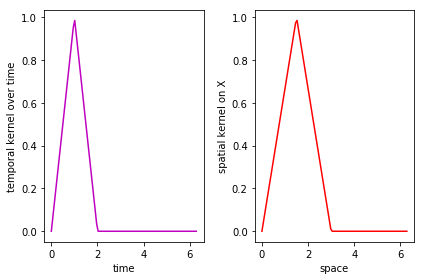

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Create an instance of the Hawkes Class for kernels defined in the following
"""

import numpy as np
import matplotlib.pyplot as plt
from HawkesClass import Hawkes

#the temporal kernel
def HawkesIntensity_temporal(time):
    a = 1 
    b = 2 
    IndInTemp = (time < b/2) & (time > 0)
    IndDecTemp = (time >= b/2) & (time < b)
    return 2*a/b * (time)*IndInTemp + ((-(2*a)/b)* (time) + 2*a )*IndDecTemp
 
    
#the spatial kernel
def g(space):
    a = 1 
    b = 3 
    IndDecSpat = (space > b/2) & (space < b)
    IndInSpat = (space <= b/2) & (space >= 0)
    return ((-(2*a)/b)* space + 2*a )*IndDecSpat + 2*a/b * space*IndInSpat

def Base(x):
    mu = 0.5
    return mu

# Plotting the kernels

x = np.linspace(0,2*np.pi,100)

plt.subplot(1, 2, 1)
plt.plot(x, HawkesIntensity_temporal(x), 'm')
plt.xlabel('time')
plt.ylabel('temporal kernel over time')


plt.subplot(1, 2, 2)
plt.plot(x, g(x), 'r')
plt.xlabel('space')
plt.ylabel('spatial kernel on X')

plt.tight_layout()

plt.show()


# -------------- Creating an instance of the Hawkes Class
G = Hawkes(Base, g, HawkesIntensity_temporal)

The function *propogate_by_amount* allows to advance the process by a given number of steps.

/home/jens/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/home/jens/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


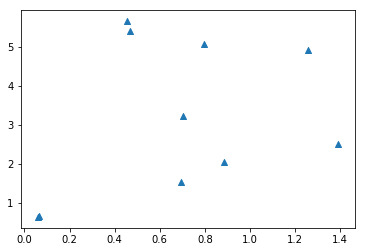

In [2]:
G.propogate_by_amount(10)

plt.scatter(G.Events[0,1:],G.Events[1,1:], marker = "^")
plt.show()  

/home/jens/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/home/jens/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


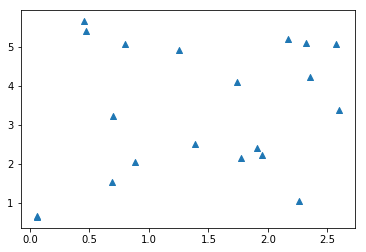

In [3]:
G.propogate_by_amount(10)

plt.scatter(G.Events[0,1:],G.Events[1,1:], marker = "^")
plt.show()

In [10]:
print('All simulated Events for G:')
print(G.Events)

All simulated Events for G:
[[ 0.          0.05922309  0.06312566  0.45399672  0.46985659  0.69381781
   0.70255476  0.79631626  0.88528811  1.25645341  1.39151447  1.73747959
   1.7724636   1.90778391  1.95104354  2.16855812  2.25811473  2.32270274
   2.35691126  2.57161814  2.59747689]
 [ 0.          0.62888385  0.66682871  5.66175757  5.39695618  1.53792741
   3.22324839  5.07132719  2.03909651  4.91229149  2.50641468  4.10702128
   2.1452852   2.39923836  2.21886993  5.19518948  1.03779157  5.08316135
   4.23110578  5.07609868  3.37457643]]


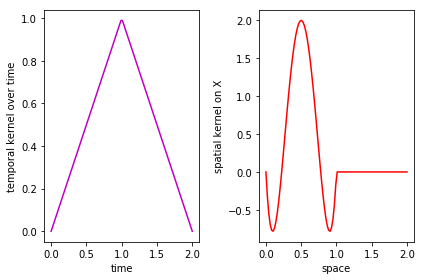

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Create an instance of the Hawkes Class for kernels defined in the following
"""

import numpy as np
import matplotlib.pyplot as plt
from HawkesClass import Hawkes

#the temporal kernel
def HawkesIntensity_temporal(time):
    a = 1 
    b = 2 
    IndInTemp = (time < b/2) & (time > 0)
    IndDecTemp = (time >= b/2) & (time < b)
    return 2*a/b * (time)*IndInTemp + ((-(2*a)/b)* (time) + 2*a )*IndDecTemp
 

#the spatial kernel    
def h(space):
    a = 2.0
    b = 1.0
    Ind = (space >= 0) & (space <= b)
    return (261/5* a/b**4.0 * (space - b/2)**4.0 - 341.0/20.0*a/b**2.0* (space - b/2)**2.0 + a)*Ind

def Base(x):
    mu = 0.5
    return mu


#  -------------- Plotting the kernels
x = np.linspace(0,2,100)

plt.subplot(1, 2, 1)
plt.plot(x, HawkesIntensity_temporal(x), 'm')
plt.xlabel('time')
plt.ylabel('temporal kernel over time')


plt.subplot(1, 2, 2)
plt.plot(x, h(x), 'r')
plt.xlabel('space')
plt.ylabel('spatial kernel on X')

plt.tight_layout()

plt.show()

# -------------- Creating an instance of the Hawkes Class
H = Hawkes(Base, h, HawkesIntensity_temporal)

/home/jens/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


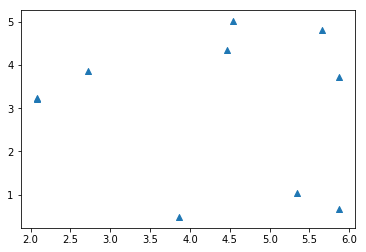

In [4]:
H.propogate_by_amount(10)

plt.scatter(H.Events[0,1:],H.Events[1,1:], marker = "^")
plt.show()  

In [24]:
print('All simulated Events for H:')
print(H.Events)

All simulated Events for H:
[[ 0.          0.01374738  0.45273     0.86484687  0.92724861  1.05955719
   1.2619927   1.58894705  1.63185468  2.05980257  2.27906242  2.57359337
   2.77580539  2.78107289  2.99447388  3.45768256  3.56184432  3.59301362
   3.70056475  3.74808609  3.82038467]
 [ 0.          0.36482363  0.48358052  0.75493607  1.08120875  5.24351558
   1.35149803  0.92185281  1.52217395  5.91181407  2.14543265  5.76380987
   6.1620617   0.5584224   6.25288526  2.80680286  1.76319709  0.71080159
   2.01727996  0.88584419  1.44856881]]


/home/jens/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


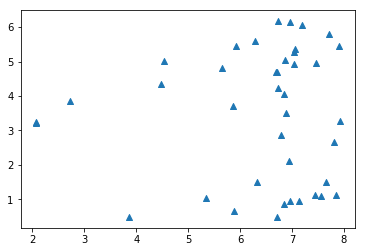

In [5]:
H.propogate_by_amount(30)

plt.scatter(H.Events[0,1:],H.Events[1,1:], marker = "^")
plt.show()  

In [9]:
import numpy as np
print(np.cumsum(H.PoissEvent))

[   0.65009966    3.2671318     4.16921662    4.45494084    5.0069203
    5.98458841    6.85601007    6.9931276     8.42397433    8.71821923
   10.80924078   11.91395686   12.40477009   12.4695014    15.04295949
   15.80230515   16.90530586   17.89736658   18.18050185   18.83307397
   19.35227182   20.85451202   22.11467031   22.82174159   23.3239939
   25.41900004   25.95632124   26.00446672   27.91897967   28.65037827
   29.65180726   29.8689554    30.21667894   30.47226782   30.74173672
   31.55692556   32.71668413   34.68267666   37.27160589   37.90158425
   38.33615664   39.33915669   39.3394626    39.4436732    40.92748117
   40.95496637   41.77199152   42.07373276   42.65071111   43.00938162
   43.09972648   44.38382192   44.46392814   45.16880043   45.92469146
   47.38549372   47.57253288   47.58538249   48.29322443   50.60118201
   53.46478011   54.72247578   56.92078761   57.56761279   58.73696169
   58.99871018   60.1071582    60.34830449   60.72232505   61.05983328
   64.02

Negative parts of the kernel lead to an inhibiting behaviour. SOURCE showed that in this case the stability of the process only depends on the positive parts of the function. According to branching process theory we need to ensure that the "evolution rate" is smaller than one which translates in our case to
$$\displaystyle\int_{X\times[0,\infty)} \lambda(s,t)\mathrm d(s,t) < 1$$.
Choosing the parameters accordingly will be done in the next cell

In [30]:
import scipy.optimize as opt
from scipy.integrate import quad

param = 1.3

def K(space):
    a = 2.0
    b = param
    Ind = (space >= 0) & (space <= b)
    return (261/5* a/b**4.0 * (space - b/2)**4.0 - 341.0/20.0*a/b**2.0* (space - b/2)**2.0 + a)*Ind

n1 = opt.fsolve(K,param/3.0)
n2 = opt.fsolve(K,2*param/3.0)

print(quad(K,n1,n2))


(0.9008083553313299, 1.0000981768635618e-14)


In [1]:
h = lambda x: [x-1 if x-1>= 0 else 0]

In [3]:
h(0)

[0]